<a href="https://colab.research.google.com/github/mango766/ml_learning/blob/main/03%E7%BA%BF%E6%80%A7%E5%9B%9E%E5%BD%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 线性回归模型

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "train_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
import numpy as np

X = 2 * np.random.rand(100,1)#生成100行1列的向量
y = 4 + 3 * X + np.random.randn(100,1)


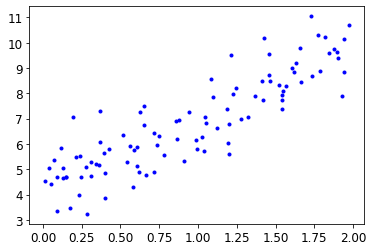

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X,y,'b.')


标准方程

In [ ]:
X_b = np.c_[np.ones((100, 1)), X]

theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [ ]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [ ]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

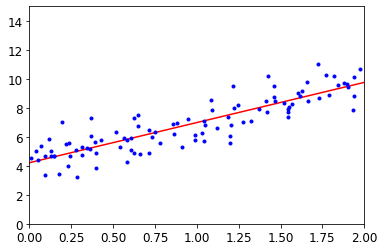

In [ ]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X,y, 'b.')
plt.axis([0,2,0,15])
plt.show()

使用线性回归

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_,lin_reg.coef_


(array([4.21509616]), array([[2.77011339]]))

In [ ]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

也可以直接调用最小二乘

In [ ]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond = 1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [ ]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

# 2 梯度下降实现

批量梯度下降

In [ ]:
eta = 0.1 #学习率
n_iterations = 1000 #迭代次数
m = 100

theta = np.random.randn(2,1)

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients

theta

array([[4.21509616],
       [2.77011339]])

随机梯度下降,使用学习率调度,学习率逐步降低,从而在随机中逐渐逼近最优值,这个过程叫模拟退火.

In [ ]:
n_epochs = 50
t0, t1 = 5, 50#学习率
def learning_schedule(t):
  return t0 / (t + t1)

theta = np.random.randn(2,1)#randn函数返回一个或一组样本，具有标准正态分布,两行一列

for epoch in range(n_epochs):
  for i in range(m):
    random_index = np.random.randint(m)#生成小于m的一个随机整数
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(epoch * m +i)
    theta = theta - eta * gradients
  
theta

array([[4.18475289],
       [2.73036719]])

使用sgd类,最大迭代次数为1000次,默认学习调度从0.1开始

In [ ]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty=None, eta0 = 0.1)
sgd_reg.fit(X, y.ravel())


SGDRegressor(eta0=0.1, penalty=None)

In [ ]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.22609703]), array([2.79227913]))

# 3 多项式回归

生成非线性数据

In [ ]:
m = 100
X = 6 * np.random.rand(m,1) - 3 #生成-3 ，3 的一些数据

y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)  


In [ ]:
X[0]

array([2.94407494])

In [ ]:
X_poly[0]

array([2.94407494, 8.66757727])

将x的平方看成一个特征，可以将线性回归模型拟合到训练数据中

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.89554823]), array([[0.95707476, 0.49025797]]))

# 4 学习曲线

在不同大小的训练子集上多次训练，从而生成学习曲线

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)#训练集验证集比例8:2
  train_errors , val_errors = [], []
  for m in range (1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])#取到m个元素
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
  plt.plot(np.sqrt(train_errors),"r-+", linewidth = 2, label = "train")
  plt.plot(np.sqrt(val_errors),"b-", linewidth = 2, label = "val")

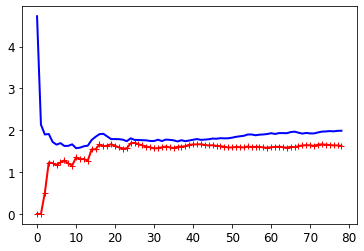

In [ ]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

随着训练集大小的扩大，误差基本持平

接下来看一下10阶多项式模型的训练曲线

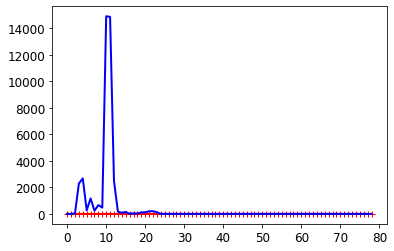

In [ ]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 10, include_bias = False)),
    ("lin_reg", LinearRegression()),
])
plot_learning_curves(polynomial_regression, X, y)

# 5 正则化线性模型

## 5.1 岭回归

线性回归的正则化版本，将参数也加入成本函数中，

从而求取参数theta的公式有了些许变化。

alpha越大，对应求解的theta越小，对应拟合曲线约平滑，从而减小方差，增大偏差。

In [ ]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1, solver = "cholesky")#使用cholesky矩阵分解技术
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])#x = 1.5,预测

array([[5.07720864]])

In [ ]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])
#公式y = 0.5x平方+x+2+r, 大概4.6到5.6之间。

array([5.08461165])

## 5.2 Lasso回归

与岭回归类似，向成本函数增加一个正则项，增加为l1范数

In [ ]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])


array([5.04247738])

## 5.3 弹性网络

弹性网络介于岭回归于Lasso回归之间。正则项为两者的简单混合，混合比为r；
通常来说，应该避免穿线性回归，当你觉得实际特征只有少数几个有用时，应该使用Lasso或者弹性网络。

In [ ]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha = 0.1, l1_ratio=0.5)#混合比为0.5
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([5.04191364])

## 5.4 提前停止法

使用**随机**和**小批量梯度下降**时，可能曲线并不是那么平滑，一种解决方案是设置**最小值**，仅当验证误差超过误差最小值**一段时间后停止**，并且**回滚**模型参数到验证误差最小的位置。

In [ ]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [ ]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 90, include_bias = False)),
    ("std_scaler", StandardScaler()),

])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)
sgd_reg = SGDRegressor(max_iter = 1, tol = -np.infty, warm_start=True, penalty=None, learning_rate="constant", eta0 = 0.0005)

minium_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train)
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minium_val_error:
    minium_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)



# 6 逻辑回归

使用回归算法用于分类，例如预测是否为垃圾邮件的概率，若概率大于50%，则属于，否则，不属于。

这样，它就成了一个二元分类器。

## 6.1 估测概率

逻辑函数是一个sigmoid函数，输出一个介于0到1之间的数字。

6.2 训练成本函数

不能直接求出theta的闭市方程，求偏导数后使用梯度下降算法

## 6.3 决策边界

使用鸢尾花数据集测试逻辑回归，首先基于花瓣宽度这一特征，创建分类器

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [ ]:
X = iris["data"][:, 3:]#  X[:,  m:n]，即取所有数据的第m到n-1列数据，含左不含右
y = (iris["target"] == 2).astype(np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

log_reg.fit(X,y)

LogisticRegression()

看看花瓣宽度在0-3厘米的鸢尾花，模型估算出的概率

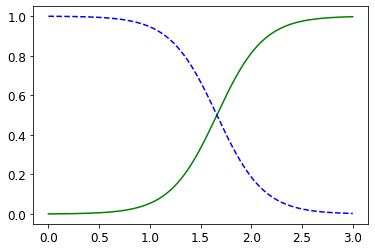

In [ ]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1],"g-",label = "Iris virginica")
plt.plot(X_new, y_proba[:,0],"b--",label = "Not Iris virginica");

In [ ]:
log_reg.predict([[1.7],[1.5]])

array([1, 0])

6.4 Softmax回归

逻辑回归模型经过推广，可以直接支持多个类别。也叫多元逻辑回归

In [ ]:
X = iris["data"][:,(2,3)]
y = iris["target"]
softmax_reg = LogisticRegression(multi_class="multinomial",solver = "lbfgs", C = 10)
softmax_reg.fit(X,y)


LogisticRegression(C=10, multi_class='multinomial')

In [ ]:
softmax_reg.predict([[5,2]])

array([2])

In [ ]:
softmax_reg.predict_proba([[5,2]])#输出概率

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])